# Описание проекта:

Я работаю в стартапе, который продаёт продукты питания. Мне нужно изучить, как пользователи нашего мобильного приложения ведут себя в воронке продаж. Я хочу узнать, сколько пользователей доходит до покупки, а сколько застревает на предыдущих шагах. После этого я проведу A/A/B-тест, чтобы узнать, какой шрифт в приложении лучше - старый или новый. Создание двух контрольных групп вместо одной поможет убедиться в точности проведенного тестирования и понять, сколько времени и данных потребуется для дальнейших тестов.

## Откроем файл с данными и изучим общую информацию

In [ ]:
import pandas as pd
import numpy as np
import datetime as d
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import seaborn as sns

In [ ]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


## Подготовим данные

Посмотрим на данные

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет, данные в нужном нам типе, ничего менять не надо, проверим на дубликаты

In [ ]:
df.duplicated().sum() # Проверим на дубликаты, и удалим их

413

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)

### Изменим название колонок

In [ ]:
df = df.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id_hash','EventTimestamp':'event_timestamp','ExpId':'exp_id'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Так стало удобнее

### Также приведем столбец с датой в читаемый формат, и добавим столбец с датой

In [ ]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = pd.to_datetime(df['event_timestamp']).dt.date

In [ ]:
df

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


## Изучим и проверим данные

In [ ]:
df['event_name'].value_counts() # события в логах

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [ ]:
logs_count = df['device_id_hash'].count()
print(f"Всего в логе {logs_count} событий")

pers = df['device_id_hash'].nunique()
print(f"Всего пользователей в логе: {pers}")

mean = int(df.groupby('device_id_hash').agg({'event_name':'count'}).mean())
print(f"В среднем на пользователя {mean} события")

d_mi = df['date'].min()
d_ma = df['date'].max()
print(f"События начинается с  {d_mi}  до  {d_ma}")

Всего в логе 243713 событий
Всего пользователей в логе: 7551
В среднем на пользователя 32 события
События начинается с  2019-07-25  до  2019-08-07


### Построим гистограмму по дате и времени

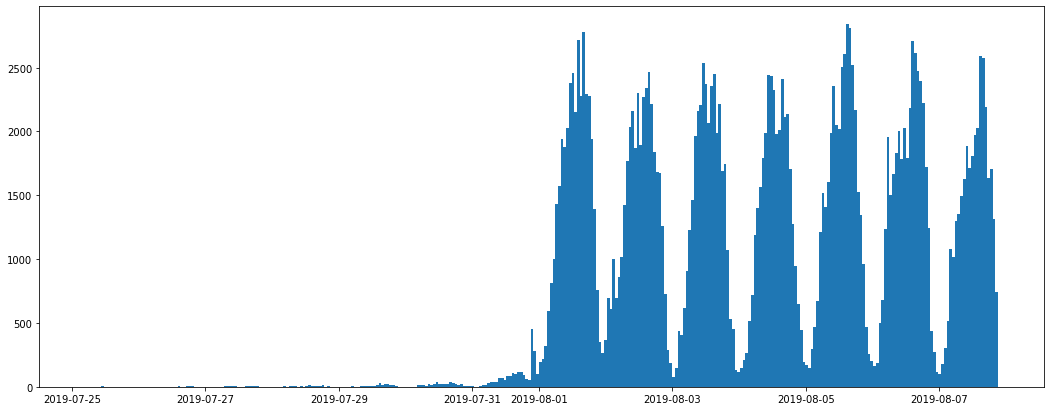

In [ ]:
time_count = df['event_timestamp'].count()
pers_df = df['device_id_hash'].nunique()
plt.figure(figsize=(18,7))
plt.hist(df['event_timestamp'], bins=14*24);

Очивидно, что полные данные начинаются с 2019-08-01, отбросим данные до этого момента

In [ ]:
data = df[df['event_timestamp']>'2019-08-01']

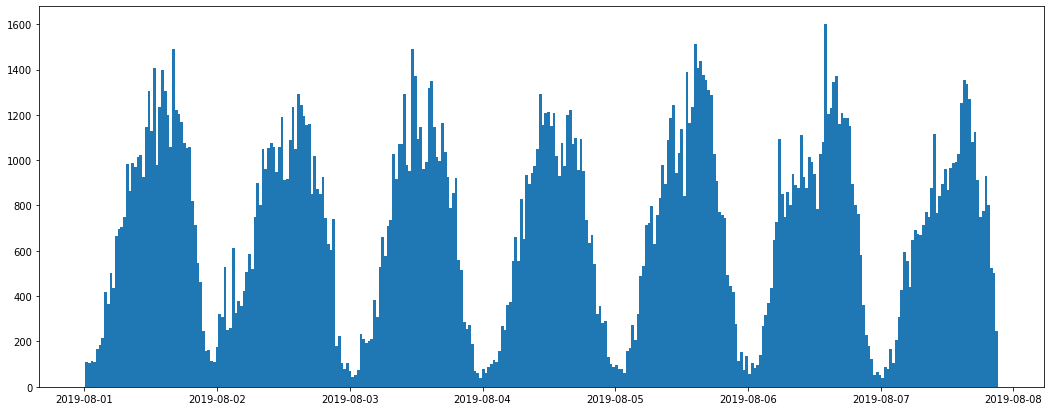

In [ ]:
new_time_count = data['event_timestamp'].count()
plt.figure(figsize=(18,7))
plt.hist(data['event_timestamp'], bins=14*24);

In [ ]:
count = abs(new_time_count-time_count)
div = round(100-new_time_count/time_count*100,2)
print(f"Данных стало меньше на {count} записей, это на {div}% меньше от начального количества данных")

pers_2 = data['device_id_hash'].nunique()

print(f"В новых данных пользователей: {pers_2}, это на {pers_df-pers_2} меньше чем в неотфильтрованных данных")

Данных стало меньше на 2826 записей, это на 1.16% меньше от начального количества данных
В новых данных пользователей: 7534, это на 17 меньше чем в неотфильтрованных данных


In [ ]:
data.groupby('exp_id')['device_id_hash'].count() # пользователи трёх экспериментальных групп

exp_id
246    79302
247    77022
248    84563
Name: device_id_hash, dtype: int64

## Изучите воронку событий

In [ ]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [ ]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [ ]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [ ]:
data['device_id_hash'].nunique()

7534

In [ ]:
us_ev = data.groupby('event_name')['device_id_hash'].agg(['count','nunique']).sort_values(by='count',ascending=False)
us_ev['cr'] = round(us_ev['nunique']/us_ev['count']*100,2)
us_ev

,count,nunique,cr
event_name,,,
MainScreenAppear,117328,7419,6.32
OffersScreenAppear,46333,4593,9.91
CartScreenAppear,42303,3734,8.83
PaymentScreenSuccessful,33918,3539,10.43
Tutorial,1005,840,83.58


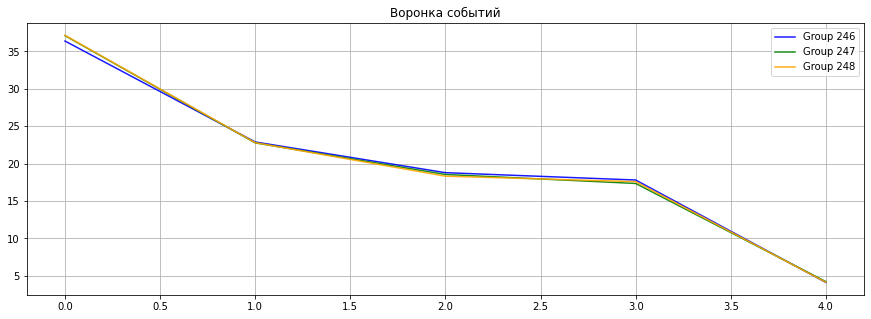

In [ ]:
gr_246 = data[data['exp_id']==246]
gr_246 = gr_246.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_246= list(round(gr_246['device_id_hash']/gr_246['device_id_hash'].sum()*100,2))

gr_247 = data[data['exp_id']==247]
gr_247 = gr_247.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_247 = list(round(gr_247['device_id_hash']/gr_247['device_id_hash'].sum()*100,2))

gr_248 = data[data['exp_id']==248]
gr_248 = gr_248.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_248 = list(round(gr_248['device_id_hash']/gr_248['device_id_hash'].sum()*100,2))

x = [0, 1, 2, 3, 4]

plt.figure(figsize=(15,5))
plt.grid()
plt.plot( gr_246, color='blue', alpha=0.9, label='Group 246')
plt.plot( gr_247, color='green', alpha=0.9, label='Group 247')
plt.plot( gr_248, color='orange', alpha=0.9, label='Group 248')
plt.title('Воронка событий')
plt.legend()
plt.show()

### Посмотрим воронку событий по каждой группе

In [ ]:
data.head()
vor = data[data['event_name']!='Tutorial']

gr_246 = vor[vor['exp_id']==246]
gr_246 = gr_246.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_246['% с прошлого шага'] = round((gr_246['device_id_hash']/gr_246['device_id_hash'].shift(1))*100,1)
print(f"Группа 246{gr_246}")
print()
print()

gr_247 = vor[vor['exp_id']==247]
gr_247 = gr_247.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_247['% с прошлого шага'] = round((gr_247['device_id_hash']/gr_247['device_id_hash'].shift(1))*100,1)
print(f"Группа 247{gr_247}")
print()
print()

gr_248 = vor[vor['exp_id']==248]
gr_248 = gr_248.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_248['% с прошлого шага'] = round((gr_248['device_id_hash']/gr_248['device_id_hash'].shift(1))*100,1)
print(f"Группа 248{gr_248}")
print()
print()

Группа 246                         device_id_hash  % с прошлого шага
event_name                                                
MainScreenAppear                   2450                NaN
OffersScreenAppear                 1542               62.9
CartScreenAppear                   1266               82.1
PaymentScreenSuccessful            1200               94.8


Группа 247                         device_id_hash  % с прошлого шага
event_name                                                
MainScreenAppear                   2476                NaN
OffersScreenAppear                 1520               61.4
CartScreenAppear                   1238               81.4
PaymentScreenSuccessful            1158               93.5


Группа 248                         device_id_hash  % с прошлого шага
event_name                                                
MainScreenAppear                   2493                NaN
OffersScreenAppear                 1531               61.4
CartScreenAppear      

Мы выяснили, что:
- с первого шага на второй переходило 61.4 - 62.9% пользователей
- с первого шага на второй переходило 80.3 - 82.1% пользователей
- с первого шага на второй переходило 93.5 -  96% пользователей

In [ ]:
vor = data[data['event_name']!='Tutorial']

gr_246 = data[data['exp_id']==246]
gr_246 = gr_246.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_246['%']= round(gr_246['device_id_hash']/gr_246['device_id_hash'].sum()*100,2)
print(f"Группа 246{gr_246}")
print()
print()

gr_247 = data[data['exp_id']==247]
gr_247 = gr_247.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_247['%']= round(gr_247['device_id_hash']/gr_247['device_id_hash'].sum()*100,2)
print(f"Группа> 247{gr_247}")
print()
print()

gr_248 = data[data['exp_id']==248]
gr_248 = gr_248.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending= False)
gr_248['%']= round(gr_248['device_id_hash']/gr_248['device_id_hash'].sum()*100,2)
print(f"Группа 248{gr_248}")


Группа 246                         device_id_hash      %
event_name                                    
MainScreenAppear                   2450  36.37
OffersScreenAppear                 1542  22.89
CartScreenAppear                   1266  18.79
PaymentScreenSuccessful            1200  17.81
Tutorial                            278   4.13


Группа> 247                         device_id_hash      %
event_name                                    
MainScreenAppear                   2476  37.09
OffersScreenAppear                 1520  22.77
CartScreenAppear                   1238  18.55
PaymentScreenSuccessful            1158  17.35
Tutorial                            283   4.24


Группа 248                         device_id_hash      %
event_name                                    
MainScreenAppear                   2493  37.13
OffersScreenAppear                 1531  22.80
CartScreenAppear                   1230  18.32
PaymentScreenSuccessful            1181  17.59
Tutorial                 

## Изучим результаты эксперимента

### клиенты в группах

In [ ]:
exp_num = data.groupby('exp_id').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash',ascending=False)
exp_num

,device_id_hash
exp_id,
248,2537
247,2513
246,2484


 Напомним, что 246 и 247 — контрольные группы, а 248 — экспериментальная

#### Проведем А/А-эксперимент для  выборок 246 и 247, вспомним  критерии успешного A/A-теста:
- Количество пользователей, попавших в различные группы, отличается не более, чем на 0.5%
- Различие ключевых метрик по группам не более 1% и не имеет статистической значимости

#### Сформулируем гипотезы
- Нулевая гипотеза: Нет статистически значимых различий между экспериментальными группами и контрольными группами.
- Альтернативная гипотеза: Есть статистически значимые различия между экспериментальными группами и контрольными группами.

In [ ]:
diff = round(100-exp_num.loc[246,'device_id_hash']/exp_num.loc[247,'device_id_hash']*100,2)
print(f"Выборка под номером '246' меньше выборки '247' на {diff} %")

Выборка под номером '246' меньше выборки '247' на 1.15 %


### разделим выборки по группам

In [ ]:
group_6 = data[data['exp_id']==246]
group_7 = data[data['exp_id']==247]
group_8 = data[data['exp_id']==248]

In [ ]:
def z_test(df1, df2, event_name, alpha, n):
    # уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
     # число пользователей в df1 и df2
    user_number = np.array([df1['device_id_hash'].nunique(),
                            df2['device_id_hash'].nunique()])
    # число пользователей, совершивших переданное функции событие в df1 и df2
    success = np.array([df1[df1['event_name'] == event_name]['device_id_hash'].nunique(),
                        df2[df2['event_name'] == event_name]['device_id_hash'].nunique()])
    # пропорции совершения события в df1 и df2
    p1 = success[0]/user_number[0]
    p2 = success[1]/user_number[1]
        # пропорция совершения события в комбинированном датасете:
    p_combined = (success[0]+success[1])/(user_number[0]+user_number[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference/np.sqrt(p_combined*(1 - p_combined)*(1/user_number[0] + 1/user_number[1]))
   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    # так как тест двусторонний (либо раличий нет, либо различия есть), то удваиваем результат
    p_value = (1 - distr.cdf(abs(z_value)))*2
    print('Событие в логе:', event_name)
    print('p-value: ', '{0:.2%}'.format(p_value))
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [ ]:
z_test(group_6,group_7,'MainScreenAppear',0.05,2)

Событие в логе: MainScreenAppear
p-value:  75.71%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_7,'OffersScreenAppear',0.05,2)

Событие в логе: OffersScreenAppear
p-value:  24.81%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_7,'CartScreenAppear',0.05,2)

Событие в логе: CartScreenAppear
p-value:  22.88%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_7,'PaymentScreenSuccessful',0.05,2)

Событие в логе: PaymentScreenSuccessful
p-value:  11.46%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Выводы:
- Группы 246 и 247 не различны

### Проведем A/B-test, сравним группу с изменённым шрифтом

#### Сравним две группы: 246 и 248

In [ ]:
z_test(group_6,group_8,'MainScreenAppear',0.05,2)

Событие в логе: MainScreenAppear
p-value:  29.50%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_8,'OffersScreenAppear',0.05,2)

Событие в логе: OffersScreenAppear
p-value:  20.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_8,'CartScreenAppear',0.05,2)

Событие в логе: CartScreenAppear
p-value:  7.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_6,group_8,'PaymentScreenSuccessful',0.05,2)

Событие в логе: PaymentScreenSuccessful
p-value:  21.23%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Сравним две группы: 247 и 248

In [ ]:
z_test(group_7,group_8,'MainScreenAppear',0.05,2)

Событие в логе: MainScreenAppear
p-value:  45.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_7,group_8,'OffersScreenAppear',0.05,2)

Событие в логе: OffersScreenAppear
p-value:  91.98%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_7,group_8,'CartScreenAppear',0.05,2)

Событие в логе: CartScreenAppear
p-value:  57.86%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_test(group_7,group_8,'PaymentScreenSuccessful',0.05,2)

Событие в логе: PaymentScreenSuccessful
p-value:  73.73%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Объединим группы 246 и 247

In [ ]:
gr_246_and_247 = data.query('exp_id==246 or exp_id==247')

Проверим будет ли отличие между группами gr_246_and_247 и 248 статистически достоверным

In [ ]:
z_test(gr_246_and_247,group_8,'MainScreenAppear',0.05,2)
print()
z_test(gr_246_and_247,group_8,'OffersScreenAppear',0.05,2)
print()
z_test(gr_246_and_247,group_8,'CartScreenAppear',0.05,2)
print()
z_test(gr_246_and_247,group_8,'PaymentScreenSuccessful',0.05,2)

Событие в логе: MainScreenAppear
p-value:  29.42%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: OffersScreenAppear
p-value:  43.43%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: CartScreenAppear
p-value:  18.18%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: PaymentScreenSuccessful
p-value:  60.04%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Можно сделать вывод, что доли попрежнему не разные

## Выводы:
- Мы провели A/B-тест, изменение шрифта никак не повлиял на клиентов
- Шрифт никак не повлиял, это значит что пользователей не отпугнуло нововведение
- Изменение шрифта не стоит делать, так как поведение пользователя никак не изменится